In [19]:
from scipy import stats
import numpy as np
import xarray as xr
from cmocean import cm as cmo  
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import gsw
import haversine as hs

%matplotlib inline

## Load data for April 2022 glider

In [2]:
# original file via opendap (for velocities)
raw = xr.open_dataset('https://thredds.aodn.org.au/thredds/dodsC/IMOS/ANFOG/slocum_glider/Forster20220328/IMOS_ANFOG_BCEOPSTUV_20220327T233113Z_SL248_FV01_timeseries_END-20220420T220346Z.nc?TIME[0:1:983431],TIME_quality_control[0:1:983431],LATITUDE[0:1:983431],LATITUDE_quality_control[0:1:983431],LONGITUDE[0:1:983431],LONGITUDE_quality_control[0:1:983431],UCUR[0:1:983431],UCUR_quality_control[0:1:983431],VCUR[0:1:983431],VCUR_quality_control[0:1:983431],UCUR_GPS[0:1:983431],UCUR_GPS_quality_control[0:1:983431],VCUR_GPS[0:1:983431],VCUR_GPS_quality_control[0:1:983431]')
# processed file (for density)
ds = xr.open_dataset('../data/Gliders/Glider_vert_gridded_spice41.nc')
ds = ds.where((ds.dive_lat<-32.5) & (ds.dive_lat>-34),drop=True)

# bathymetry
bath = xr.open_dataset('../data/subset_ETOPO1_Ice_g_gmt4.grd')

### define function to index section by distance

In [3]:
def make_distance_dataset(ds):
    # create data
    salt = ds.PSAL_vert_binned.data
    temp = ds.TEMP_vert_binned.data
    cdom = ds.CDOM_vert_binned.data
    dens = ds.potential_density_vert_binned.data
    brun = ds.BRUNTV_vert_binned.data
    time = ds.dive_time.data
    dive_lat = ds.dive_lat.data
    dive_lon = ds.dive_lon.data
    # create coords
    DIST = (ds.dive_distance-ds.dive_distance[0]).data
    PRES = ds.PRES.data

    # put data into a dataset
    nc = xr.Dataset(
        data_vars=dict(
            salt=(["PRES", "DIST"], salt),
            temp=(["PRES", "DIST"], temp),
            cdom=(["PRES", "DIST"], cdom),
            dens=(["PRES", "DIST"], dens),
            brun=(["PRES", "DIST"], brun),
            dive_lat=(["DIST"],dive_lat),
            dive_lon=(["DIST"],dive_lon),
            time=(["DIST"],time),

            
        ),
        coords=dict(
            PRES=(["PRES"], PRES),
            DIST=(["DIST"], DIST),
        ),
        attrs=dict(description="test "+str(ds)),
    )

    return nc

### separate out section from whole mission

In [4]:
nc = make_distance_dataset(ds)
sect=nc.sel(DIST=slice(260, 295))
sect['DIST']=sect.DIST-sect.DIST[0]

### Calculate density gradients in upper 50m of water column
Need to despike (in the cross-shore direction) due to the glider being advected downstream when it's on the surface between dives - use a quantile aproach for this

In [5]:
dens_50m = (sect.dens.where(sect.PRES<50).mean('PRES')-1000)

# despike
x=dens_50m.to_pandas()    
dens_50m_despiked = x[x.between(x.quantile(.10), x.quantile(1))]

In [6]:
# Estimate density gradients at 3,5,7 and 10 km offshore by fitting a straight line to observed
# density field using linear regression  
dens_50m_despiked_r = dens_50m_despiked.where(dens_50m_despiked.index<3).dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(dens_50m_despiked_r.index, dens_50m_despiked_r)
y_pred = intercept + slope*dens_50m_despiked_r.index
print('3km gradient = '+str(slope/1000)) # need to convert from km to m

dens_50m_despiked_r = dens_50m_despiked.where(dens_50m_despiked.index<5).dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(dens_50m_despiked_r.index, dens_50m_despiked_r)
y_pred = intercept + slope*dens_50m_despiked_r.index
print('5km gradient = '+str(slope/1000)) # need to convert from km to m

dens_50m_despiked_r = dens_50m_despiked.where(dens_50m_despiked.index<7).dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(dens_50m_despiked_r.index, dens_50m_despiked_r)
y_pred = intercept + slope*dens_50m_despiked_r.index
print('7km gradient = '+str(slope/1000)) # need to convert from km to m

dens_50m_despiked_r = dens_50m_despiked.where(dens_50m_despiked.index<10).dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(dens_50m_despiked_r.index, dens_50m_despiked_r)
y_pred = intercept + slope*dens_50m_despiked_r.index
print('10km gradient = '+str(slope/1000)) # need to convert from km to m

3km gradient = 9.278397177463974e-05
5km gradient = 5.0358644841259784e-05
7km gradient = 2.9260701799370226e-05
10km gradient = 1.4384298055338677e-05


### For the first point, we need to estimate the density gradient between the mouth of the estuary and the inshore edge of the glider transect
We use the value from the Hawekesbury River estuary logger for this purpose

In [7]:
# Get the distance between logger and start of glider transect:
Hawke_rho = gsw.rho(6.9,20.37,- 10.1325) # calculate density at Hawkesbury logger
logger_location = (-33.55231729,151.3124343)
glid_start = (-33.533236904761196,151.45640638831426)
dist_est = hs.haversine(logger_location,glid_start)
print(str(dist_est) + ' km')

#Calculate density gradient from box head logger to start of glider transect
log_grad = (23.9-3.48)/(dist_est*1000)
print('coastal gradient = '+str(log_grad))


13.510691780467065 km
coastal gradient = 0.0015113955918616981


### We plug these gradients into the routines for the Heaps formulation of density driven currents provided in matlab by Simpson & Sharples (2012)
routines are available under 'resources' at https://www.cambridge.org/shelfseas.

In [8]:
# 10km offshore
heap_10_lon = sect.sel(DIST=10,method='nearest').dive_lon.values
heap_10_lat = sect.sel(DIST=10,method='nearest').dive_lat.values
heap_10_U = 0.01
heap_10_V = 0.095

# 7km offshore
heap_7_lon = sect.sel(DIST=7,method='nearest').dive_lon.values
heap_7_lat = sect.sel(DIST=7,method='nearest').dive_lat.values
heap_7_U = 0.04
heap_7_V = 0.15

# 5km offshore
heap_5_lon = sect.sel(DIST=5,method='nearest').dive_lon.values
heap_5_lat = sect.sel(DIST=5,method='nearest').dive_lat.values
heap_5_U = 0.08
heap_5_V = 0.19

# 3km offshore
heap_3_lon = sect.sel(DIST=3,method='nearest').dive_lon.values
heap_3_lat = sect.sel(DIST=3,method='nearest').dive_lat.values
heap_3_U = 0.1
heap_3_V = 0.18

# from estuary to start of glider section (13500 m distance)
heap_0_lon = sect.sel(DIST=0,method='nearest').dive_lon.values
heap_0_lat = sect.sel(DIST=0,method='nearest').dive_lat.values
heap_0_U = 0.38
heap_0_V = 0.47

# Plot

/Users/neilmalan/miniconda3/envs/Ncomms2023/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/neilmalan/miniconda3/envs/Ncomms2023/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


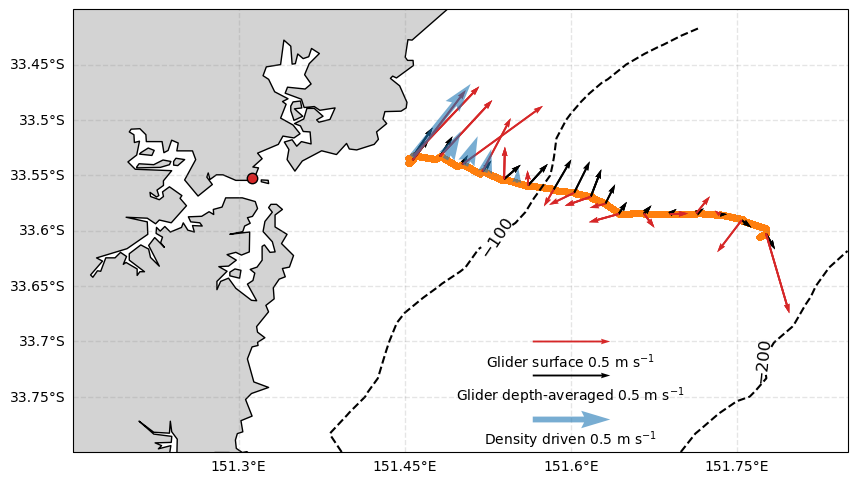

In [9]:
bath = bath.sel(x=slice(151.15, 151.85),y=slice(-33.8, -33.4))

#subsect raw data into just the section we want:
sect22=ds.sel(PROFILE=slice(2150, 2380))
r_sect=raw.sel(TIME=slice(sect22.dive_time[0].values,sect22.dive_time[-1].values))

fig = plt.figure(figsize=(10,12))
ax=plt.subplot(111,projection=ccrs.PlateCarree())
ax.set_extent([151.15, 151.85, -33.8, -33.4], crs=ccrs.PlateCarree())
cs=bath.z.plot.contour(levels=[-100, -200, -1000, -2000],colors='k',transform=ccrs.PlateCarree())
cs.clabel(fontsize=12, inline=1)

Q = plt.quiver(r_sect.LONGITUDE, r_sect.LATITUDE, r_sect.UCUR
               , r_sect.VCUR, units='width', scale=5,zorder=1e35)
plt.quiverkey(Q, X=151.6, Y=-33.73, U=.5, color='black',coordinates='data',
             label='Glider depth-averaged 0.5 m s$^{-1}$', labelpos='S',zorder=10)

Q = plt.quiver(r_sect.LONGITUDE, r_sect.LATITUDE, r_sect.UCUR_GPS
               , r_sect.VCUR_GPS, units='width', scale=5,zorder=1e35,color='tab:red')
plt.quiverkey(Q, X=151.6, Y=-33.7, U=.5, color='tab:red',coordinates='data',
             label='Glider surface 0.5 m s$^{-1}$', labelpos='S',zorder=10)

Q = plt.quiver([heap_10_lon,heap_7_lon,heap_5_lon,heap_3_lon,heap_0_lon], 
               [heap_10_lat,heap_7_lat,heap_5_lat,heap_3_lat,heap_0_lat], 
               [heap_10_U,heap_7_U,heap_5_U,heap_3_U,heap_0_U],
               [heap_10_V,heap_7_V,heap_5_V,heap_3_V,heap_0_V], units='width',
               scale=5,zorder=1e35,alpha=.6,color='tab:blue')

plt.quiverkey(Q, X=151.6, Y=-33.77, U=.5, color='tab:blue',coordinates='data',
             label='Density driven 0.5 m s$^{-1}$', labelpos='S',zorder=10)

# add location of box head logger
plt.plot(151.3124343,-33.55231729,'.',ms = 15, mfc = 'tab:red',mec = 'black')


# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.MaxNLocator(6)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.add_feature(cfeature.GSHHSFeature('h', edgecolor='black', facecolor='lightgrey'))
plt.scatter(r_sect.LONGITUDE,r_sect.LATITUDE,s=10,c='tab:orange',transform=ccrs.PlateCarree())

### Load glider sections

In [12]:
# Load the glider section dataset using xarray
glider_dataset = xr.open_dataset('../data/glidersection_APR2022.nc')

# Interpolate over NaN values in the density data
interpolated_dens = glider_dataset['dens'].interpolate_na(dim='DIST', method='linear')

In [17]:
# load glider section of geostrophic velocities

geo = xr.open_dataset('../data/GVabs.nc')

# Extract the geo_vel data and the associated dimensions for plotting
geo_vel_data = geo['geo_vel'].values
distance = geo['DISTANCE'].values

# Mask NaN values in the geo_vel data
geo_vel_masked = np.ma.masked_invalid(geo_vel_data)

# Remove columns corresponding to NaN values in distance
valid_distance = distance[~np.isnan(distance)]
valid_geo_vel = geo_vel_masked[:, ~np.isnan(distance)]

# Adjust the distance values to start from zero and cumulatively sum the differences
cumulative_distance = np.cumsum(np.diff(valid_distance, prepend=valid_distance[0]))

# Create synthetic depth levels starting at 0.5m and ending at 200.5m with an interval of 1m
synthetic_depth_levels = np.arange(0.5, 200.5, 1)

# Define contour levels for the filled contour plot
contour_levels = np.linspace(-0.5, 0.5, 21)

# Plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


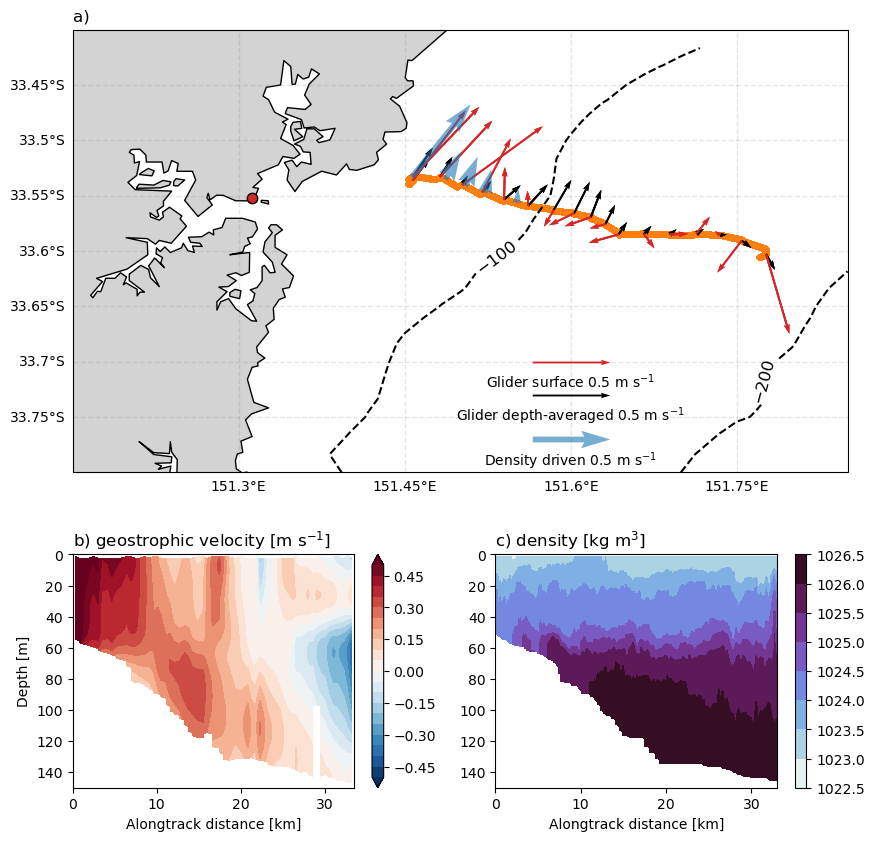

In [21]:
# Create a figure
fig = plt.figure(figsize=(10, 10))

# Define the grid layout
gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1])

# Create the subplots
ax0 = fig.add_subplot(gs[0, :])  # Top wide plot spanning both columns
# trick to add cartopy axes (https://github.com/matplotlib/matplotlib/issues/20392)
ss = ax0.get_subplotspec()
ax0.remove()
ax0 = fig.add_subplot(ss, projection=ccrs.PlateCarree())

ax0.set_extent([151.15, 151.85, -33.8, -33.4], crs=ccrs.PlateCarree())
cs=bath.z.plot.contour(levels=[-100, -200, -1000, -2000],colors='k',transform=ccrs.PlateCarree())
cs.clabel(fontsize=12, inline=1)

Q = plt.quiver(r_sect.LONGITUDE, r_sect.LATITUDE, r_sect.UCUR
               , r_sect.VCUR, units='width', scale=5,zorder=1e35)
plt.quiverkey(Q, X=151.6, Y=-33.73, U=.5, color='black',coordinates='data',
             label='Glider depth-averaged 0.5 m s$^{-1}$', labelpos='S',zorder=10)

Q = plt.quiver(r_sect.LONGITUDE, r_sect.LATITUDE, r_sect.UCUR_GPS
               , r_sect.VCUR_GPS, units='width', scale=5,zorder=1e35,color='tab:red')
plt.quiverkey(Q, X=151.6, Y=-33.7, U=.5, color='tab:red',coordinates='data',
             label='Glider surface 0.5 m s$^{-1}$', labelpos='S',zorder=10)

Q = plt.quiver([heap_10_lon,heap_7_lon,heap_5_lon,heap_3_lon,heap_0_lon], 
               [heap_10_lat,heap_7_lat,heap_5_lat,heap_3_lat,heap_0_lat], 
               [heap_10_U,heap_7_U,heap_5_U,heap_3_U,heap_0_U],
               [heap_10_V,heap_7_V,heap_5_V,heap_3_V,heap_0_V], units='width',
               scale=5,zorder=1e35,alpha=.6,color='tab:blue')

plt.quiverkey(Q, X=151.6, Y=-33.77, U=.5, color='tab:blue',coordinates='data',
             label='Density driven 0.5 m s$^{-1}$', labelpos='S',zorder=10)

# add location of box head logger
plt.plot(151.3124343,-33.55231729,'.',ms = 15, mfc = 'tab:red',mec = 'black')


# Gridlines
gl = ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.MaxNLocator(6)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax0.add_feature(cfeature.GSHHSFeature('h', edgecolor='black', facecolor='lightgrey'))
plt.scatter(r_sect.LONGITUDE,r_sect.LATITUDE,s=10,c='tab:orange',transform=ccrs.PlateCarree())

plt.title('a)',loc='left')

ax1 = fig.add_subplot(gs[1, 0])  # Bottom-left narrow plot
contour_filled = plt.contourf(cumulative_distance, synthetic_depth_levels, valid_geo_vel, levels=contour_levels, cmap='RdBu_r', extend='both')
plt.colorbar(contour_filled)
plt.gca().invert_yaxis()  # Invert y-axis for depth representation
plt.ylim(150,0)
 
plt.ylabel('Depth [m]')
plt.xlabel('Alongtrack distance [km]')
plt.title('b) geostrophic velocity [m s$^{-1}$]',loc='left')
    
ax2 = fig.add_subplot(gs[1, 1])  # Bottom-right narrow plot
interpolated_dens.plot.contourf(levels=10
                       ,cmap=cmo.dense
                       ,ylim=(150,0)
                       ,xlim=(0,33)         
                       ,cbar_kwargs={'label': ''})
plt.ylabel('')
plt.xlabel('Alongtrack distance [km]')
plt.title('c) density [kg m$^{3}$]',loc='left')

plt.savefig("Fig_6.eps", format='eps', bbox_inches='tight')